## Bank Marketing 数据集 随机森林的编程实践

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Importing the generic python libraries for Data processing and manipulation
import math
import pandas as pd
import numpy as np

# Importing libarries for spilting the train and test dataset
from sklearn.model_selection import train_test_split

# Importing Libraries for Feature Scaling
from sklearn.preprocessing import StandardScaler

# Importing libraries for Dimensionality Reduction
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA

# Importing libraries for different Classifiers for training
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn import tree
#from natsort import index_natsorted
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Importing GridSearchCV for Hyper Parameter tuning of models
from sklearn.model_selection import GridSearchCV

# Importing the Visualization libraries
import matplotlib.pyplot as plt 
import seaborn as sns
# import graphviz

# Importing Libraries for Resampling
from sklearn.utils import resample

# Importing the Performance metrics libraries
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score  
from sklearn.metrics import precision_score, recall_score, roc_auc_score

# Importing the missing number libraries
import missingno as msno
%matplotlib inline

pd.set_option('display.max_columns', None)

# Importing Plotly graphic library for vizualization
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Importing the warnings library
import warnings
warnings.filterwarnings('ignore')

# Importing Libraries related to Handling Imbalanced Classes
from imblearn.over_sampling import SMOTE
from collections import Counter


## 数据预处理

In [5]:
# Using the read_excel function of pandas library for importing the data from excel sheet
data = pd.read_csv("D:\\25Spring\\25Spring_MachineLearning\\MachineLearning\\ML_exercise_04\\bank.csv")#这是你bank文件的路径地址
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [6]:
# Below code will segregate the different features by role and data type
metadata = []
for feature in data.columns:
    # Defining the role
    if feature == 'deposit':
        role = 'target'
    else:
        role = 'input'
         
    # Defining the level
    if 'bin' in feature or feature == 'target':
        level = 'binary'
    elif 'cat' in feature:
        level = 'nominal'
    elif data[feature].dtype == float:
        level = 'interval'
    else:
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
     
    # Defining the data type 
    dtype = data[feature].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    feature_dict = {
        'varname': feature,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    metadata.append(feature_dict)
    
meta1 = pd.DataFrame(metadata, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta1.set_index('varname', inplace=True)
meta1

,role,level,keep,dtype
varname,,,,
age,input,ordinal,True,int64
job,input,ordinal,True,object
marital,input,ordinal,True,object
education,input,nominal,True,object
default,input,ordinal,True,object
balance,input,ordinal,True,int64
housing,input,ordinal,True,object
loan,input,ordinal,True,object
contact,input,ordinal,True,object


In [7]:
# Below code will segregate the different features by role, category and data type
metadata = []
for feature in data.columns:
    # Defining the role
    if feature == 'deposit':
        use = 'target'
    else:
        use = 'input'
         
    # Defining the type
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature:
        type = 'categorical'
    elif data[feature].dtype == float or isinstance(data[feature].dtype, float):
        type = 'real'
    else:
        type = 'integer'
        
    # Initialize preserve to True for all variables except for id
    preserve = True

    
    # Defining the data type 
    dtype = data[feature].dtype
    
    category = 'none'
    # Defining the category
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
    
    
    # Creating a Dict that contains all the metadata for the variable
    feature_dictionary = {
        'varname': feature,
        'use': use,
        'type': type,
        'preserve': preserve,
        'dtype': dtype,
        'category' : category
    }
    metadata.append(feature_dictionary)
    
meta2 = pd.DataFrame(metadata, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
meta2.set_index('varname', inplace=True)
meta2

,use,type,preserve,dtype,category
varname,,,,,
age,input,integer,True,int64,none
job,input,integer,True,object,none
marital,input,integer,True,object,none
education,input,categorical,True,object,none
default,input,integer,True,object,none
balance,input,integer,True,int64,none
housing,input,integer,True,object,none
loan,input,integer,True,object,none
contact,input,integer,True,object,none


In [8]:
meta2[(meta2.type == 'categorical') & (meta2.preserve)].index

Index(['education'], dtype='object', name='varname')

In [9]:
# Select the Features whose data type is Object
print(data.dtypes)
data.select_dtypes(object)

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
deposit      object
dtype: object


,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
0,admin.,married,secondary,no,yes,no,unknown,may,unknown,yes
1,admin.,married,secondary,no,no,no,unknown,may,unknown,yes
2,technician,married,secondary,no,yes,no,unknown,may,unknown,yes
3,services,married,secondary,no,yes,no,unknown,may,unknown,yes
4,admin.,married,tertiary,no,no,no,unknown,may,unknown,yes
...,...,...,...,...,...,...,...,...,...,...
11157,blue-collar,single,primary,no,yes,no,cellular,apr,unknown,no
11158,services,married,secondary,no,no,no,unknown,jun,unknown,no
11159,technician,single,secondary,no,no,no,cellular,aug,unknown,no
11160,technician,married,secondary,no,no,yes,cellular,may,failure,no


In [10]:
#seperating the ICU lable column
# without_deposit_column = data.drop('deposit', axis = 1)       
deposit_column = data['deposit']

#finding columns that are not of type float or int
colums_to_convert = data.select_dtypes(object).columns   
colums_to_convert

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'deposit'],
      dtype='object')

In [11]:
#performing hotcoding using the get_dummies method of pandas libraries
data = pd.get_dummies(data, columns = colums_to_convert)      
data.head(500)

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,deposit_no,deposit_yes
0,59,2343,5,1042,1,-1,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True
1,56,45,5,1467,1,-1,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True
2,41,1270,5,1389,1,-1,0,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True
3,55,2476,5,579,1,-1,0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True
4,54,184,5,673,2,-1,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,31,294,17,536,5,-1,0,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,True,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True
496,27,0,17,991,5,-1,0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True
497,44,292,17,1153,4,-1,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,True,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True
498,40,2998,18,623,3,-1,0,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True


In [12]:
data = data.drop('deposit_yes', axis = 1)  

In [13]:
data. rename(columns = {'deposit_no':'deposit'}, inplace = True)

In [14]:
#adding the deposit column again at the last position
       
data.head(5)

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,deposit
0,59,2343,5,1042,1,-1,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
1,56,45,5,1467,1,-1,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
2,41,1270,5,1389,1,-1,0,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
3,55,2476,5,579,1,-1,0,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
4,54,184,5,673,2,-1,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False


NaN values = 0

In total, there are 0 variables with missing values


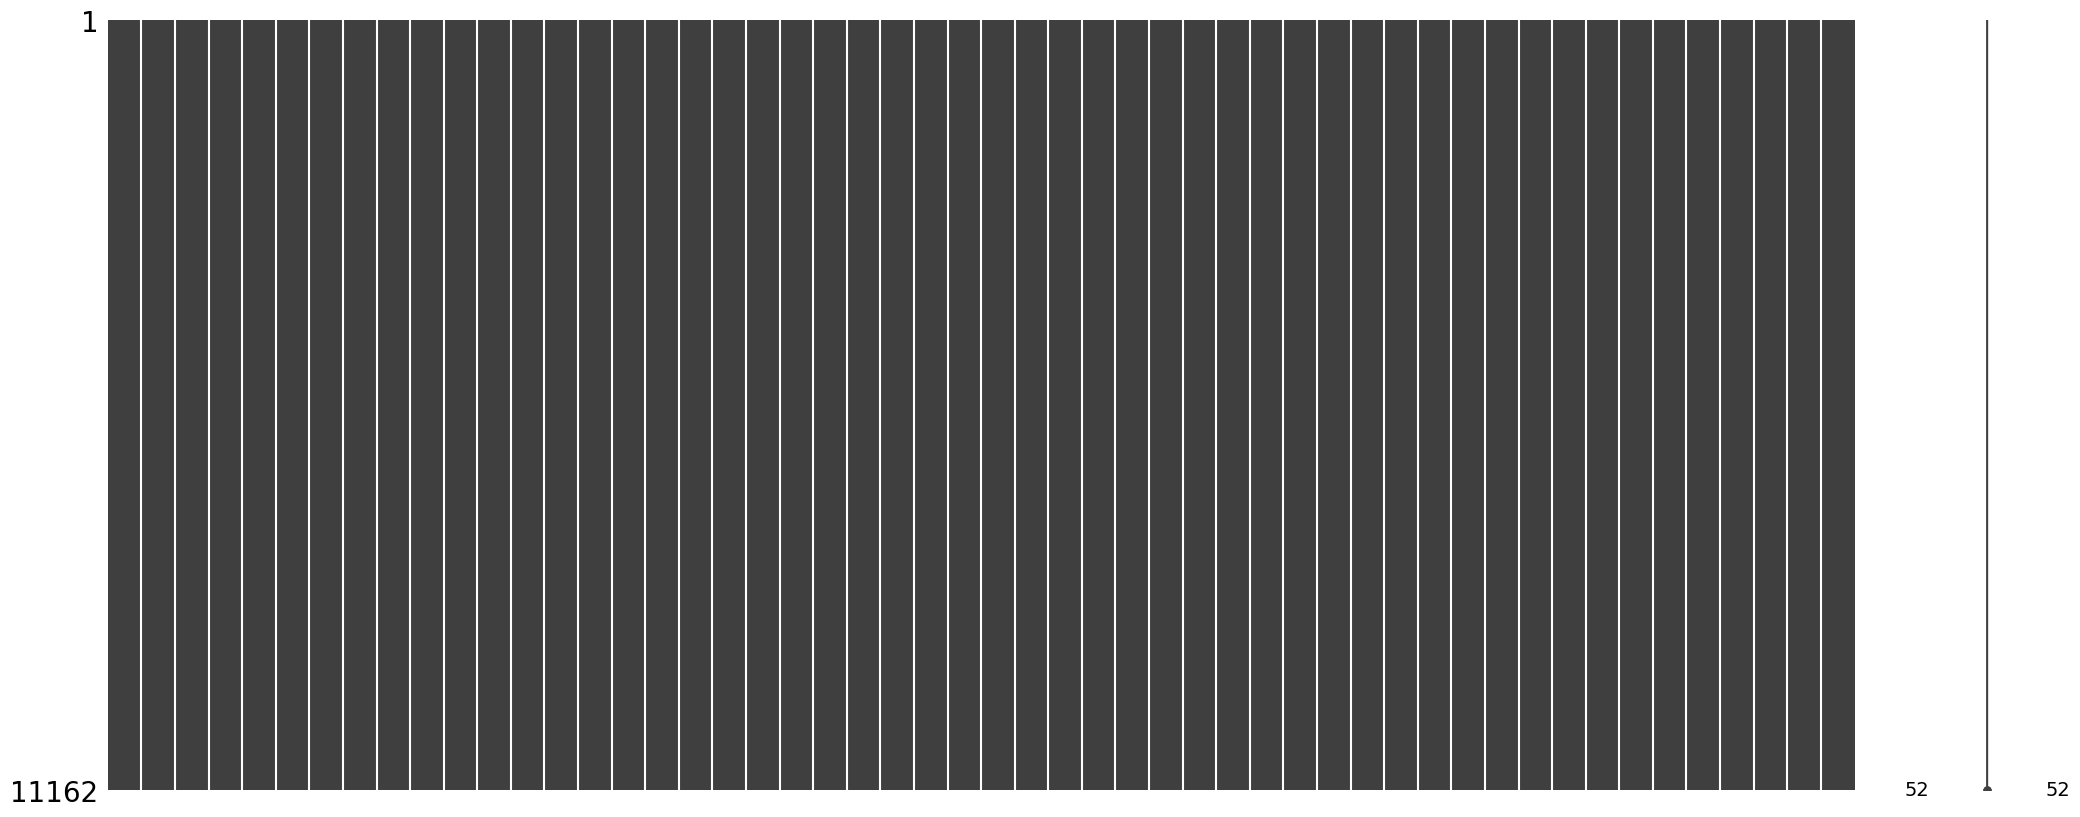

In [15]:
# Verify if any missing values in dataset
msno.matrix(data)

print('NaN values =', data.isnull().sum().sum())
print("""""")
vars_with_missing = []
for feature in data.columns:
    missings = data[feature].isna().sum()
    if missings > 0 :
        vars_with_missing.append(feature)
        missings_perc = missings / data.shape[0]
        print('Variable {} has {} records ({:.2%}) with missing values.'.format(feature, missings, missings_perc))
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

In [16]:
data.shape

(11162, 52)

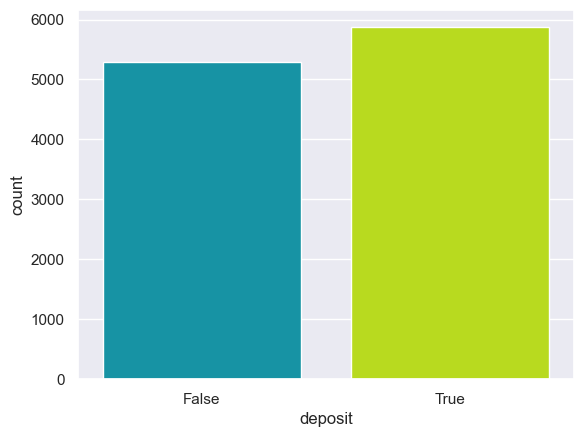

In [17]:
# Check if any imbalanced classes in dataset
sns.set_style('white')
sns.set(font_scale=1)
plt.figure()
sns.countplot(x=data.deposit,palette='nipy_spectral')
plt.show()

In [18]:
plt1 = plt

In [19]:
X_data = np.array(data.drop(['deposit'], axis = 1))
Y_data = np.array(data[['deposit']])
print(X_data.shape)
print(Y_data.shape)

(11162, 51)
(11162, 1)


In [20]:
X_data_df = data.drop(['deposit'], axis = 1)

## 数据集划分

In [24]:
# Splitting the data into train and test dataset using train_test_split library
xtrain, xvalid, ytrain, yvalid = train_test_split(X_data, Y_data, stratify=Y_data, random_state=0, train_size=0.8)

练习：# 任务：按8:2划分数据集
调整train_size参数
xtrain, xvalid, ytrain, yvalid =...

In [25]:
# Using the library StandardScaler to scale the data before training the data 
scaler = StandardScaler()

In [26]:
ytrain.shape

(8929, 1)

In [27]:
ytrain = ytrain.reshape(ytrain.size, 1)

In [28]:
xtrain_scaled = scaler.fit_transform(xtrain)
xvalid_scaled = scaler.transform(xvalid)


In [29]:
print(xtrain_scaled.shape)
print(ytrain.shape)

(8929, 51)
(8929, 1)


In [30]:
def ass(y_true,y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  accuracy=(tp+tn)/(tp+fp+fn+tn)
  specificity = tn/(tn+fp)
  sensitivity=tp/(tp+fn)
  print("Accuracy:",accuracy*100)
  print("Sensitivity:",sensitivity*100)
  print("Specificity:",specificity*100)
  print("ROC_AUC_Score:",roc_auc_score(y_true, y_pred)*100)
  

In [31]:
xtrain_scaled.shape

(8929, 51)

In [32]:
ytrain = ytrain.squeeze()

In [33]:
ytrain.shape

(8929,)

In [34]:
# Function to diaply the Confusion Matrix 混淆矩阵
def plot_cm(actual, pred):
    cm = confusion_matrix(actual, pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt1.title("Decision Tree Confusion Matrix")
    plt1.ylabel('Actual label')
    plt1.xlabel('Predicted label \n\n' + 
               "Accuracy: {:.2f}\n".format(accuracy_score(actual, pred)) + 
               "Precision: {:.2f}\n".format(precision_score(actual, pred, average='weighted')) + 
               "Recall: {:.2f}\n".format(recall_score(actual, pred, average='weighted')) +
               "F1: {:.2f}\n".format(f1_score(actual, pred, average='weighted')))

## 随机森林算法

In [35]:
# Using Random FOrest Classifier to train and predict on original dataset
RF_object = RandomForestClassifier()
RF_object.fit(xtrain_scaled, ytrain)
y_pred=RF_object.predict(xvalid_scaled)
ass(yvalid,y_pred)

Accuracy: 85.44558889386475
Sensitivity: 82.8936170212766
Specificity: 88.27977315689981
ROC_AUC_Score: 85.58669508908821


练习：使用n_estimators=100训练随机森林
提示：修改RandomForestClassifier参数


In [36]:
#练习
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# 初始化随机森林分类器（设置随机种子为42）
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# 练习1：使用训练集训练模型
# 提示：使用fit方法，注意ytrain需要转换形状
rf_clf.fit(xtrain_scaled, ytrain.squeeze())

# 练习2：进行5折交叉验证（使用准确率作为评分标准）
# 提示：使用cross_val_score
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(
    rf_clf, 
    xtrain_scaled, 
    ytrain.squeeze(), 
    cv=5,
    scoring='accuracy'
)


# 练习3：预测训练集和测试集结果
y_train_pred = rf_clf.predict(xtrain_scaled)
y_test_pred = rf_clf.predict(xvalid_scaled)

# 练习4：计算评估指标
# 训练集准确率
train_acc = accuracy_score(ytrain, y_train_pred)
# 测试集准确率
test_acc = accuracy_score(yvalid, y_test_pred)
# 测试集F1分数
test_f1 = f1_score(yvalid, y_test_pred, average='weighted')
# 混淆矩阵
conf_matrix = confusion_matrix(yvalid, y_test_pred)

print(f"训练集准确率: {train_acc:.2f}")
print(f"测试集准确率: {test_acc:.2f}") 
print(f"测试集F1分数: {test_f1:.2f}")
print("混淆矩阵:")
print(conf_matrix)

训练集准确率: 1.00
测试集准确率: 0.86
测试集F1分数: 0.86
混淆矩阵:
[[935 123]
 [190 985]]


## 可视化

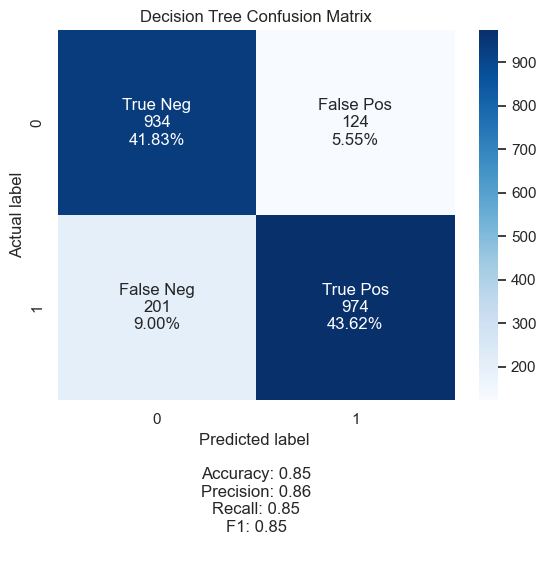

In [37]:
# Call the custom function to display the Confusion Matrix
plot_cm(yvalid, y_pred)